# PowerX strategy [Freqtrade ready]
This notebook is a copy of the original study: [Improved PowerX strategy by DCD](./Improved%20PowerX%20strategy%20by%20DCD.ipynb)

In [5]:
# Load libraries
import pandas as pd
import pandas_ta as pta
import talib.abstract as ta
from pandas import DataFrame
import numpy as np
import mplfinance as mpf

In [6]:
dataframe = pd.read_json("./data/BTC_USDT-1h.json")
dataframe.columns=['date','open','high','low','close','volume']
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))
dataframe.tail(5)

,date,open,high,low,close,volume
38233,2022-01-01 11:00:00,46871.09,47007.73,46756.77,46758.87,732.88793
38234,2022-01-01 12:00:00,46758.87,47150.48,46756.30,47074.05,582.15009
38235,2022-01-01 13:00:00,47074.05,47199.67,46935.09,47023.24,454.14412
38236,2022-01-01 14:00:00,47023.24,47100.00,46850.18,46926.22,503.66220
38237,2022-01-01 15:00:00,46920.01,47491.14,46871.69,47219.04,1515.95305


In [7]:
dataframe['rsi'] = ta.RSI(dataframe, timeperiod=14)
stoch = ta.STOCH(
    dataframe,
    fastk_period=14,
    slowk_period=3,
    slowk_matype=0,
    slowd_period=3,
    slowd_matype=0,
)
dataframe['slowd'] = stoch['slowd']
dataframe['slowk'] = stoch['slowk']
macd = ta.MACD(
        dataframe,
        fastperiod=12,
        fastmatype=0,
        slowperiod=26,
        slowmatype=0,
        signalperiod=9,
        signalmatype=0,
    )
dataframe["macd"] = macd["macd"]
dataframe["macdsignal"] = macd["macdsignal"]
dataframe["macdhist"] = macd["macdhist"]
dataframe['atr'] = ta.ATR(dataframe, timeperiod=14)

In [9]:
def buy_sell(data):
    rsi_level = 50
    slowd_level = 50
    
    signal = []
    
    for i in range(len(dataframe)):
        if (dataframe['rsi'][i] > rsi_level) & (dataframe['slowd'][i] > slowd_level) & (dataframe['macd'][i] > dataframe['macdsignal'][i]):
            signal.append('buy')
        else:
            signal.append('sell')
    
    return signal
dataframe['signal'] = buy_sell(dataframe)
dataframe['advice_changed'] = dataframe['signal'].shift(+1) != dataframe['signal']

In [10]:
atr_sl_mult = 1
atr_tp_mult = 2

for i, row in dataframe.iterrows():
    if row['advice_changed'] == True and row['signal'] == 'buy':
        dataframe.loc[i,'takeprofit'] = row['close'] + (row['atr'] * atr_tp_mult)
        dataframe.loc[i,'stoploss'] = row['close'] - (row['atr'] * atr_sl_mult)
        dataframe.loc[i,'buyprice'] = row['close']
    elif row['advice_changed'] == True and row['signal'] == 'sell':
        dataframe.loc[i,'takeprofit'] = np.nan
        dataframe.loc[i,'stoploss'] = np.nan
        dataframe.loc[i,'buyprice'] = np.nan
    else:
        dataframe.loc[i,'takeprofit'] = dataframe.loc[i-1,'takeprofit']
        dataframe.loc[i,'stoploss'] = dataframe.loc[i-1,'stoploss']
        dataframe.loc[i,'buyprice'] = dataframe.loc[i-1,'buyprice']

<ipython-input-13-7f01e0c777d7>:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(dates, price, linestyle='solid', marker=None, label='BTC price')
No handles with labels found to put in legend.


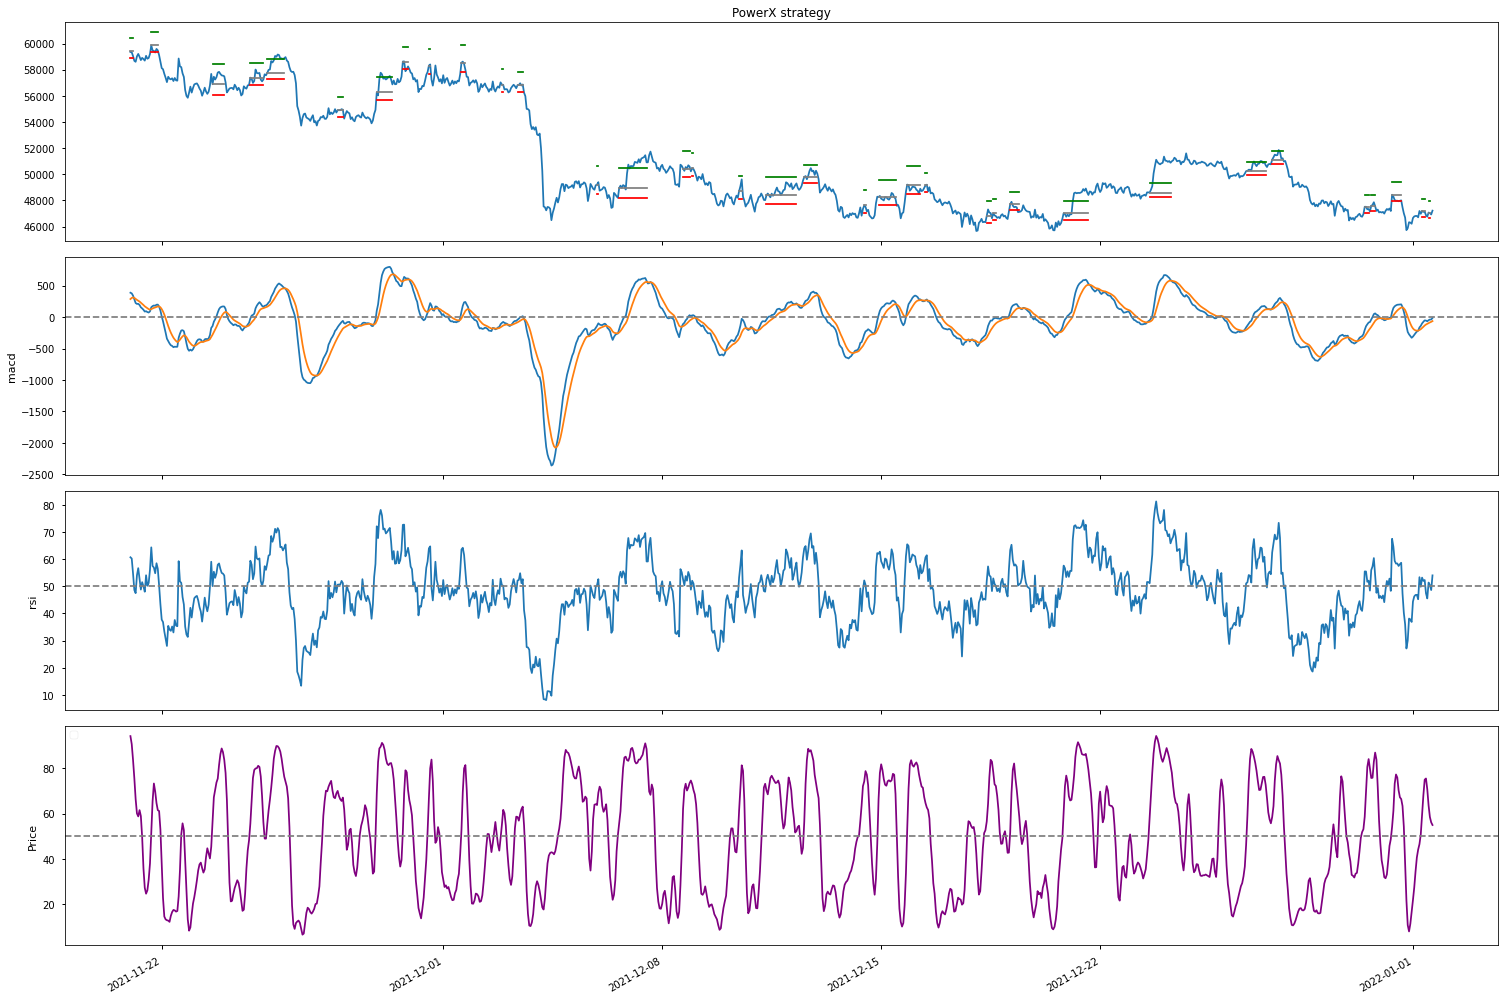

In [13]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn-notebook')
plt.figure(figsize=(21,14))

days = 1000
dates = dataframe['date'].tail(days)
price = dataframe['close'].tail(days)
buyprice = dataframe['buyprice'].tail(days)
stoploss = dataframe['stoploss'].tail(days)
takeprofit = dataframe['takeprofit'].tail(days)
slowd_level = 50
rsi_level = 50
macd = dataframe['macd'].tail(days)
macd_signal = dataframe['macdsignal'].tail(days)
slowd = dataframe['slowd'].tail(days)
rsi = dataframe['rsi'].tail(days)

plt.subplot(4, 1, 1)
plt.plot_date(dates, price, linestyle='solid', marker=None, label='BTC price')
plt.plot(dates, buyprice, label='buyprice', color='grey')
plt.plot(dates, stoploss, label='stoploss', color='red')
plt.plot(dates, takeprofit, label='takeprofit', color='green')
plt.title('PowerX strategy')
plt.xlabel('Date')

plt.subplot(4, 1, 2)
plt.plot(dates, macd, label='macd', alpha=1)
plt.plot(dates, macd_signal, label='signal', alpha=1)
plt.axhline(y=0, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('macd')

plt.subplot(4, 1, 3)
plt.plot(dates, rsi)
plt.axhline(y=50, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('rsi')

plt.subplot(4, 1, 4)
plt.plot(dates, slowd, color='purple')
plt.axhline(y=50, color='grey', linestyle='--')
# plt.xlabel('Date')
plt.ylabel('slowd')


plt.gcf().autofmt_xdate()

plt.ylabel('Price')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [12]:
dataframe[['date','advice_changed','signal','close','buyprice','takeprofit','stoploss']].tail(55)

,date,advice_changed,signal,close,buyprice,takeprofit,stoploss
38183,2021-12-30 09:00:00,False,sell,46753.42,NaN,NaN,NaN
38184,2021-12-30 10:00:00,False,sell,46952.91,NaN,NaN,NaN
38185,2021-12-30 11:00:00,True,buy,47515.45,47515.45,48404.418273,47070.965863
38186,2021-12-30 12:00:00,False,buy,47514.17,47515.45,48404.418273,47070.965863
38187,2021-12-30 13:00:00,False,buy,47321.49,47515.45,48404.418273,47070.965863
38188,2021-12-30 14:00:00,False,buy,47345.03,47515.45,48404.418273,47070.965863
38189,2021-12-30 15:00:00,True,sell,47159.41,NaN,NaN,NaN
38190,2021-12-30 16:00:00,True,buy,47578.69,47578.69,48417.748760,47159.160620
38191,2021-12-30 17:00:00,False,buy,47663.51,47578.69,48417.748760,47159.160620
38192,2021-12-30 18:00:00,False,buy,47860.75,47578.69,48417.748760,47159.160620
